<a href="https://colab.research.google.com/github/panpapap/Python_portfolio/blob/main/U_S_House_price_predicting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project overview

I will try to train a random forest model predicting future house prices 🏡. Then, I'll use backtesting to measure error and try to improve our model with new predictors.

The dataset could be find in my [github](https://github.com/panpapap/Python_portfolio/tree/main/datasets/house_prices). Retrieved from Dataquest.

* CPIAUCSL.csv - US CPI (inflation measure)
* RRVRUSQ156N.csv - rental vacancy rate, quarterly
* MORTGAGE30US.csv - mortgage interest rates, weekly
* Metro_median_sale_price_uc_sfrcondo_week.csv - median sale price for US houses
* Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_month.csv - Zillow home value index

**🧠 Skills used: pandas, numpy, matplotlib scikit-learn**

In [100]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

In [62]:
#Load files using list comprehension
fed_files = ["/content/drive/MyDrive/Portfolio_files/House price/MORTGAGE30US.csv", "/content/drive/MyDrive/Portfolio_files/House price/RRVRUSQ156N.csv", "/content/drive/MyDrive/Portfolio_files/House price/CPIAUCSL.csv"]

dfs = [pd.read_csv(f, parse_dates=True, index_col=0) for f in fed_files]

In [63]:
dfs[0]

,MORTGAGE30US
DATE,
1971-04-02,7.33
1971-04-09,7.31
1971-04-16,7.31
1971-04-23,7.31
1971-04-30,7.29
...,...
2022-07-14,5.51
2022-07-21,5.54
2022-07-28,5.30


In [64]:
dfs[1]

,RRVRUSQ156N
DATE,
1956-01-01,6.2
1956-04-01,5.9
1956-07-01,6.3
1956-10-01,5.8
1957-01-01,5.3
...,...
2021-04-01,6.2
2021-07-01,5.8
2021-10-01,5.6


In [65]:
dfs[2]

,CPIAUCSL
DATE,
1947-01-01,21.480
1947-02-01,21.620
1947-03-01,22.000
1947-04-01,22.000
1947-05-01,21.950
...,...
2022-03-01,287.708
2022-04-01,288.663
2022-05-01,291.474


The datasets are on different timelines. The MORTGAGE file is in 7-day interval, the RRVRUS file is quarterly and the CPIAUCSL file is monthly. We will have to find a way to merge these data.

In [66]:
#Using concat function to join 3 datasets
fed_data = pd.concat(dfs, axis=1)
fed_data

,MORTGAGE30US,RRVRUSQ156N,CPIAUCSL
DATE,,,
1947-01-01,NaN,NaN,21.48
1947-02-01,NaN,NaN,21.62
1947-03-01,NaN,NaN,22.00
1947-04-01,NaN,NaN,22.00
1947-05-01,NaN,NaN,21.95
...,...,...,...
2022-07-14,5.51,NaN,NaN
2022-07-21,5.54,NaN,NaN
2022-07-28,5.30,NaN,NaN


We assume that the Rental Vacancy Rate would stay the same within a quarter and Inflation measure would stay the same for the whole month.

In [67]:
#Use forward fill to fill all the missing values
fed_data = fed_data.ffill().dropna()
fed_data

,MORTGAGE30US,RRVRUSQ156N,CPIAUCSL
DATE,,,
1971-04-02,7.33,5.3,40.100
1971-04-09,7.31,5.3,40.100
1971-04-16,7.31,5.3,40.100
1971-04-23,7.31,5.3,40.100
1971-04-30,7.29,5.3,40.100
...,...,...,...
2022-07-14,5.51,5.6,295.271
2022-07-21,5.54,5.6,295.271
2022-07-28,5.30,5.6,295.271


In [68]:
#Load Zillow files using list comprehension
zillow_files = ["/content/drive/MyDrive/Portfolio_files/House price/Metro_median_sale_price_uc_sfrcondo_week.csv", "/content/drive/MyDrive/Portfolio_files/House price/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_month.csv"]

dfs = [pd.read_csv(f) for f in zillow_files]

In [69]:
dfs[0]

,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-02,2008-02-09,2008-02-16,2008-02-23,2008-03-01,...,2022-05-07,2022-05-14,2022-05-21,2022-05-28,2022-06-04,2022-06-11,2022-06-18,2022-06-25,2022-07-02,2022-07-09
0,102001,0,United States,Country,NaN,190000.0,190000.0,193000.0,189900.0,194900.0,...,369900.0,370000.0,370000.0,375000.0,375000.0,370000.0,375000.0,370000.0,370000.0,362500.0
1,394913,1,"New York, NY",Msa,NY,400000.0,418250.0,420000.0,420000.0,400000.0,...,550000.0,555000.0,550000.0,575000.0,575000.0,578000.0,590000.0,582000.0,585000.0,595000.0
2,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,497500.0,515000.0,520000.0,525000.0,498250.0,...,914000.0,925000.0,925000.0,951000.0,950000.0,920500.0,925000.0,900000.0,900500.0,906000.0
3,394463,3,"Chicago, IL",Msa,IL,245000.0,245000.0,251000.0,255000.0,255000.0,...,315000.0,310000.0,315500.0,315000.0,330000.0,324950.0,335000.0,325000.0,325000.0,315000.0
4,394514,4,"Dallas-Fort Worth, TX",Msa,TX,144250.0,148900.0,139000.0,143700.0,145900.0,...,422000.0,430000.0,430000.0,425000.0,440000.0,425000.0,427750.0,426000.0,420000.0,420000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,394528,90,"Daytona Beach, FL",Msa,FL,NaN,170000.0,182400.0,170000.0,170000.0,...,340500.0,345000.0,327700.0,345000.0,350000.0,343250.0,359900.0,352000.0,336000.0,342990.0
80,394531,91,"Des Moines, IA",Msa,IA,138000.0,160000.0,150000.0,151750.0,154500.0,...,270000.0,285250.0,295000.0,273450.0,301000.0,290000.0,300900.0,281900.0,289250.0,280000.0
81,395006,100,"Provo, UT",Msa,UT,NaN,206000.0,215500.0,210000.0,210000.0,...,527000.0,540000.0,535000.0,552500.0,543750.0,571000.0,530300.0,569900.0,539950.0,572500.0
82,394549,104,"Durham, NC",Msa,NC,210000.0,170000.0,170500.0,197500.0,180000.0,...,456000.0,450000.0,428500.0,480000.0,465000.0,440000.0,450250.0,416000.0,465000.0,435250.0


In [70]:
dfs[1]

,RegionID,SizeRank,RegionName,RegionType,StateName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,...,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31
0,102001,0,United States,Country,NaN,108641.264685,108472.728880,108532.280074,108739.077466,108986.621607,...,318648.557319,322227.276010,327377.250887,332206.790140,338002.747686,344042.433111,350515.841789,354717.722904,357473.327397,357107.271636
1,394913,1,"New York, NY",Msa,NY,188550.306900,186833.460516,186448.089063,186132.003064,186023.979536,...,573099.183713,575351.020713,577891.698212,582902.117225,588521.056859,598696.268370,607668.479848,615457.379763,619722.310507,621307.894902
2,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,186683.041088,186015.165187,185723.797105,185700.155256,185569.298179,...,854076.999683,862487.347366,874894.413168,888106.123973,902359.871460,931407.638755,950811.533011,955845.190020,933648.296046,929753.425908
3,394463,3,"Chicago, IL",Msa,IL,147341.931571,147341.152880,146420.379418,147841.918776,148371.389735,...,288899.103704,290304.887853,291998.702189,294814.368208,298667.824107,304076.779527,308802.105551,314032.378286,315084.424557,314178.550606
4,394514,4,"Dallas-Fort Worth, TX",Msa,TX,113283.512989,113199.113561,113519.423633,114048.064719,114287.444295,...,338187.525418,344409.906452,351186.037787,359878.893639,370452.369604,376522.090399,391696.585402,399613.324087,401254.775442,396903.773679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,394767,929,"Lamesa, TX",Msa,TX,NaN,NaN,NaN,NaN,NaN,...,92899.038250,92999.754549,97296.415265,98217.639150,100010.331287,101084.700150,101376.966610,103321.694906,105794.451088,106244.149398
909,753874,930,"Craig, CO",Msa,CO,66532.401041,66795.083062,67178.691523,67680.532389,67149.040671,...,244845.354879,245187.643589,253767.119261,254926.311559,253700.139970,255387.314731,254937.506748,256166.409003,266655.039121,268370.634013
910,394968,931,"Pecos, TX",Msa,TX,NaN,NaN,NaN,NaN,NaN,...,169404.973627,171295.739580,178176.871040,178929.217811,179113.938659,181811.015503,184752.025925,187573.847282,192967.342193,193366.794326
911,395188,932,"Vernon, TX",Msa,TX,NaN,NaN,NaN,NaN,NaN,...,80043.974772,80196.507293,NaN,86966.994296,88535.643138,88556.495891,88921.719463,89261.931509,92129.408692,93197.602418


In [71]:
#Tranpose the column, taking only US values
dfs = [pd.DataFrame(df.iloc[0,5:]) for df in dfs] #Cut off the first 5 columns, take only the 1st row of the data

#Create a month column to merge 2 datasets
for df in dfs:
    df.index = pd.to_datetime(df.index)
    df["month"] = df.index.to_period("M")

In [72]:
dfs[0]

,0,month
2008-02-02,190000.0,2008-02
2008-02-09,190000.0,2008-02
2008-02-16,193000.0,2008-02
2008-02-23,189900.0,2008-02
2008-03-01,194900.0,2008-03
...,...,...
2022-06-11,370000.0,2022-06
2022-06-18,375000.0,2022-06
2022-06-25,370000.0,2022-06
2022-07-02,370000.0,2022-07


In [73]:
#Merge 2 datasets using month column
price_data = dfs[0].merge(dfs[1], on="month")

In [74]:
price_data.index = dfs[0].index
price_data

,0_x,month,0_y
2008-02-02,190000.0,2008-02,206885.853266
2008-02-09,190000.0,2008-02,206885.853266
2008-02-16,193000.0,2008-02,206885.853266
2008-02-23,189900.0,2008-02,206885.853266
2008-03-01,194900.0,2008-03,205459.521952
...,...,...,...
2022-06-11,370000.0,2022-06,357473.327397
2022-06-18,375000.0,2022-06,357473.327397
2022-06-25,370000.0,2022-06,357473.327397
2022-07-02,370000.0,2022-07,357107.271636


In [75]:
del price_data["month"]

#Change the column name
price_data.columns = ["price", "value"]

In [76]:
price_data

,price,value
2008-02-02,190000.0,206885.853266
2008-02-09,190000.0,206885.853266
2008-02-16,193000.0,206885.853266
2008-02-23,189900.0,206885.853266
2008-03-01,194900.0,205459.521952
...,...,...
2022-06-11,370000.0,357473.327397
2022-06-18,375000.0,357473.327397
2022-06-25,370000.0,357473.327397
2022-07-02,370000.0,357107.271636


In [77]:
#Align fed data with Zillow data (match the date)
fed_data.index = fed_data.index + timedelta(days=2)

In [78]:
#Merge fed data and zillow data
price_data = fed_data.merge(price_data, left_index=True, right_index=True)
price_data

,MORTGAGE30US,RRVRUSQ156N,CPIAUCSL,price,value
2008-02-02,5.68,10.1,212.174,190000.0,206885.853266
2008-02-09,5.67,10.1,212.687,190000.0,206885.853266
2008-02-16,5.72,10.1,212.687,193000.0,206885.853266
2008-02-23,6.04,10.1,212.687,189900.0,206885.853266
2008-03-01,6.24,10.1,212.687,194900.0,205459.521952
...,...,...,...,...,...
2022-06-11,5.23,5.6,295.328,370000.0,357473.327397
2022-06-18,5.78,5.6,295.328,375000.0,357473.327397
2022-06-25,5.81,5.6,295.328,370000.0,357473.327397
2022-07-02,5.70,5.6,295.328,370000.0,357107.271636


In [79]:
#Change the column names
price_data.columns = ["interest", "vacancy", "cpi", "price", "value"]
price_data

,interest,vacancy,cpi,price,value
2008-02-02,5.68,10.1,212.174,190000.0,206885.853266
2008-02-09,5.67,10.1,212.687,190000.0,206885.853266
2008-02-16,5.72,10.1,212.687,193000.0,206885.853266
2008-02-23,6.04,10.1,212.687,189900.0,206885.853266
2008-03-01,6.24,10.1,212.687,194900.0,205459.521952
...,...,...,...,...,...
2022-06-11,5.23,5.6,295.328,370000.0,357473.327397
2022-06-18,5.78,5.6,295.328,375000.0,357473.327397
2022-06-25,5.81,5.6,295.328,370000.0,357473.327397
2022-07-02,5.70,5.6,295.328,370000.0,357107.271636


In [80]:
#Adjust the price to inflation measure
price_data["adj_price"] = price_data["price"] / price_data["cpi"] * 100
price_data["adj_value"] = price_data["value"] / price_data["cpi"] * 100

Price: Average prices houses sold for in that week.

Value: Zillow computed average value of all houses in the US.

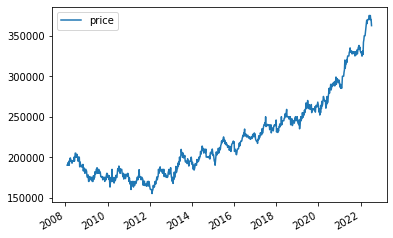

In [81]:
price_data.plot.line(y="price", use_index=True)

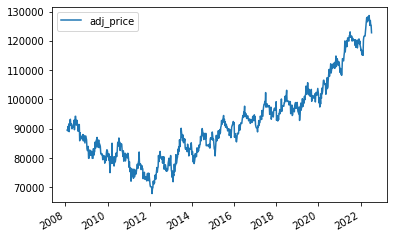

In [82]:
price_data.plot.line(y="adj_price", use_index=True)

After we took inflation out of the price, the magnitude of the price rise decrease significantly. The original prices rose from 150,000 to 350,000, meanwhile the adjusted prices rose from 70,000 to 130,000.

In [83]:
#Set up target for machine learning using pandas shift method
price_data["next_quarter"] = price_data["adj_price"].shift(-13)

In [84]:
price_data.dropna(inplace=True)

In [85]:
price_data

,interest,vacancy,cpi,price,value,adj_price,adj_value,next_quarter
2008-02-02,5.68,10.1,212.174,190000.0,206885.853266,89549.143627,97507.636782,90610.014498
2008-02-09,5.67,10.1,212.687,190000.0,206885.853266,89333.151533,97272.448841,90563.547824
2008-02-16,5.72,10.1,212.687,193000.0,206885.853266,90743.674978,97272.448841,91014.739229
2008-02-23,6.04,10.1,212.687,189900.0,206885.853266,89286.134084,97272.448841,90610.014498
2008-03-01,6.24,10.1,212.687,194900.0,205459.521952,91637.006493,96601.824254,92933.348203
...,...,...,...,...,...,...,...,...
2022-03-12,3.85,5.8,287.708,350000.0,344042.433111,121651.118495,119580.419422,125284.429516
2022-03-19,4.16,5.8,287.708,350000.0,344042.433111,121651.118495,119580.419422,126977.462347
2022-03-26,4.42,5.8,287.708,355000.0,344042.433111,123388.991617,119580.419422,125284.429516
2022-04-02,4.67,5.8,287.708,360000.0,350515.841789,125126.864738,121830.412011,125284.429516


In [86]:
price_data["change"] = (price_data["next_quarter"] > price_data["adj_price"]).astype(int)

In [87]:
price_data

,interest,vacancy,cpi,price,value,adj_price,adj_value,next_quarter,change
2008-02-02,5.68,10.1,212.174,190000.0,206885.853266,89549.143627,97507.636782,90610.014498,1
2008-02-09,5.67,10.1,212.687,190000.0,206885.853266,89333.151533,97272.448841,90563.547824,1
2008-02-16,5.72,10.1,212.687,193000.0,206885.853266,90743.674978,97272.448841,91014.739229,1
2008-02-23,6.04,10.1,212.687,189900.0,206885.853266,89286.134084,97272.448841,90610.014498,1
2008-03-01,6.24,10.1,212.687,194900.0,205459.521952,91637.006493,96601.824254,92933.348203,1
...,...,...,...,...,...,...,...,...,...
2022-03-12,3.85,5.8,287.708,350000.0,344042.433111,121651.118495,119580.419422,125284.429516,1
2022-03-19,4.16,5.8,287.708,350000.0,344042.433111,121651.118495,119580.419422,126977.462347,1
2022-03-26,4.42,5.8,287.708,355000.0,344042.433111,123388.991617,119580.419422,125284.429516,1
2022-04-02,4.67,5.8,287.708,360000.0,350515.841789,125126.864738,121830.412011,125284.429516,1


In [88]:
price_data["change"].value_counts()

1    379
0    343
Name: change, dtype: int64

In [89]:
predictors = ["interest", "vacancy", "adj_price", "adj_value"]
target = "change"

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

START = 260
STEP = 52

def predict(train, test, predictors, target):
    rf = RandomForestClassifier(min_samples_split=10, random_state=1)
    rf.fit(train[predictors], train[target])
    preds = rf.predict(test[predictors])
    return preds

def backtest(data, predictors, target):
    all_preds = []
    for i in range(START, data.shape[0], STEP):
        train = price_data.iloc[:i]
        test = price_data.iloc[i:(i+STEP)]
        all_preds.append(predict(train, test, predictors, target))
    
    preds = np.concatenate(all_preds)
    return preds, accuracy_score(data.iloc[START:][target], preds)

In [91]:
preds, accuracy = backtest(price_data, predictors, target)

In [92]:
preds

array([1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [93]:
accuracy

0.5952380952380952

In [94]:
yearly = price_data.rolling(52, min_periods=1).mean()

In [95]:
yearly_ratios = [p + "_year" for p in predictors]
price_data[yearly_ratios] = price_data[predictors] / yearly[predictors]

In [96]:
price_data

,interest,vacancy,cpi,price,value,adj_price,adj_value,next_quarter,change,interest_year,vacancy_year,adj_price_year,adj_value_year
2008-02-02,5.68,10.1,212.174,190000.0,206885.853266,89549.143627,97507.636782,90610.014498,1,1.000000,1.000000,1.0,1.0
2008-02-09,5.67,10.1,212.687,190000.0,206885.853266,89333.151533,97272.448841,90563.547824,1,0.999119,1.000000,0.998793,0.998793
2008-02-16,5.72,10.1,212.687,193000.0,206885.853266,90743.674978,97272.448841,91014.739229,1,1.005272,1.000000,1.009662,0.999195
2008-02-23,6.04,10.1,212.687,189900.0,206885.853266,89286.134084,97272.448841,90610.014498,1,1.045435,1.000000,0.995075,0.999396
2008-03-01,6.24,10.1,212.687,194900.0,205459.521952,91637.006493,96601.824254,92933.348203,1,1.063032,1.000000,1.016948,0.993996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-12,3.85,5.8,287.708,350000.0,344042.433111,121651.118495,119580.419422,125284.429516,1,1.235955,0.977317,1.021141,1.049231
2022-03-19,4.16,5.8,287.708,350000.0,344042.433111,121651.118495,119580.419422,126977.462347,1,1.326140,0.980494,1.019749,1.047093
2022-03-26,4.42,5.8,287.708,355000.0,344042.433111,123388.991617,119580.419422,125284.429516,1,1.397289,0.983692,1.03262,1.044965
2022-04-02,4.67,5.8,287.708,360000.0,350515.841789,125126.864738,121830.412011,125284.429516,1,1.462275,0.986911,1.045474,1.062065


In [97]:
preds, accuracy = backtest(price_data, predictors + yearly_ratios, target)

In [98]:
accuracy

0.6536796536796536

In [99]:
pred_match = (preds == price_data[target].iloc[START:])
pred_match[pred_match == True] = "green"
pred_match[pred_match == False] = "red"

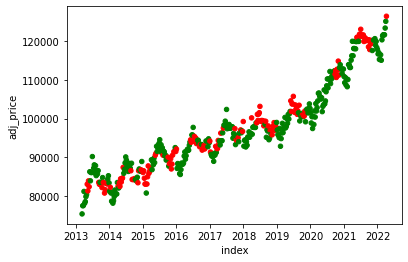

In [101]:
plot_data = price_data.iloc[START:].copy()

plot_data.reset_index().plot.scatter(x="index", y="adj_price", color=pred_match)

In [102]:
from sklearn.inspection import permutation_importance

rf = RandomForestClassifier(min_samples_split=10, random_state=1)
rf.fit(price_data[predictors], price_data[target])

result = permutation_importance(rf, price_data[predictors], price_data[target], n_repeats=10, random_state=1)

In [103]:
result["importances_mean"]

array([0.17451524, 0.15540166, 0.27576177, 0.34861496])

In [104]:
predictors

['interest', 'vacancy', 'adj_price', 'adj_value']